# Predicting Water Pump Functionality in Tanzania (HydroLogic Project)
Authored by Farzaneh Gerami 
March – June 2025

# Imports

In [387]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway

import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind # checking if the data is random or depends on other

import joblib


# Sprint 1 & 2 - Feature Engineering

## Read numerical Dataset

In [388]:
# Read Merged data as an original data
df = pd.read_csv("../data/processed/df_encoded.csv")
df.head()

,public_meeting,permit,funder,installer,subvillage,wpt_name,scheme_name,payment_type,source,quality_group,...,dayofweek_recorded,district_code,gps_height,latitude,longitude,month_recorded,population,region_code,year_recorded,construction_year
0,1.0,0.0,217.0,72.0,217.0,2883.0,112.0,0.0,8.0,2.0,...,-1.507557,-0.063252,1.041618,-1.409594,-0.075453,-0.453624,-0.148887,-0.244909,2011.0,1999.0
1,0.0,1.0,39.0,29.0,39.0,671.0,23488.0,2.0,5.0,2.0,...,-0.482809,-0.377167,1.054603,1.207517,-0.166424,-0.453624,0.211544,0.264940,2013.0,2010.0
2,1.0,1.0,7.0,573.0,7.0,2.0,8.0,5.0,0.0,2.0,...,-1.507557,-0.167890,0.025921,0.639250,0.883415,-0.784064,0.148311,0.321590,2013.0,2009.0
3,1.0,1.0,860.0,190.0,860.0,1.0,23488.0,2.0,3.0,2.0,...,-1.507557,6.005768,-0.584363,-1.850589,1.273221,-1.114504,-0.256385,4.230433,2013.0,1986.0
4,1.0,1.0,1.0,113.0,1.0,1400.0,23488.0,2.0,5.0,2.0,...,-0.482809,-0.481805,-0.963807,1.316870,-1.522644,0.868134,-0.378636,0.151640,2011.0,1996.0


In [389]:
df.shape

(47520, 36)

## I have to check if all are numerical and then do the MI

In [390]:
df.dtypes

public_meeting                 float64
permit                         float64
funder                         float64
installer                      float64
subvillage                     float64
wpt_name                       float64
scheme_name                    float64
payment_type                   float64
source                         float64
quality_group                  float64
funder_installer               float64
management_group               float64
lga                            float64
subvillage_funder_installer    float64
extraction_type_class          float64
status_group                   float64
quantity                       float64
management                     float64
basin                          float64
source_class                   float64
water_quality                  float64
ward                           float64
scheme_management              float64
region                         float64
waterpoint_type                float64
amount_tsh               

In [ ]:
X = df.copy()
y = X.pop("status_group")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer or float dtypes
discrete_features = X.dtypes.isin([int, float])

# Mutual Information

In [392]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their

ward                  0.181524
quantity              0.105630
waterpoint_type       0.064730
longitude             0.060815
region                0.042519
scheme_name           0.032012
source                0.024397
quality_group         0.017843
population            0.015325
scheme_management     0.008135
public_meeting        0.004239
dayofweek_recorded    0.000000
Name: MI Scores, dtype: float64

Interpretation: Each value in the output tells us how much information that feature contributes to predicting the target. Higher values = more useful for prediction.

# Plot

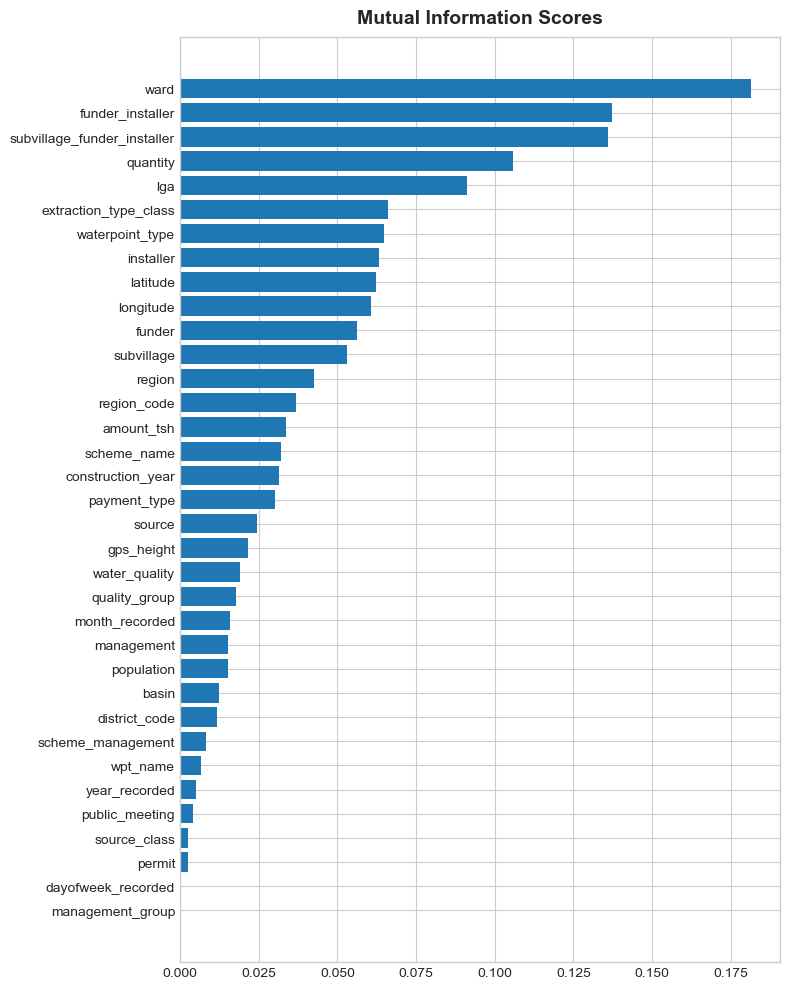

In [393]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores)

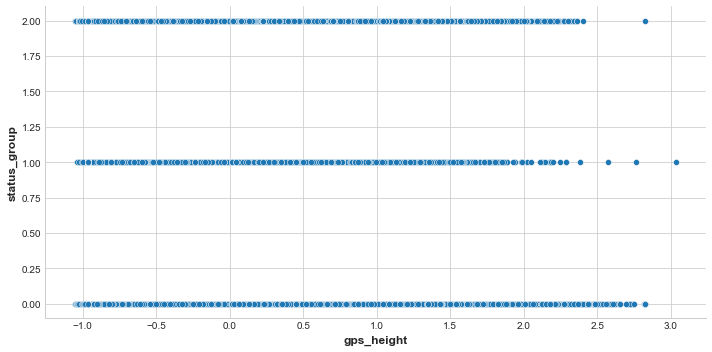

In [394]:
sns.relplot(x="gps_height", y="status_group", data=df, height=5, aspect=2)


Interpretation: this plot showing how elevation (gps_height) relates to the waterpoint’s functional status.Points are fairly spread out, indicating weak direct correlation between elevation and status. 
Some clustering exists, e.g., certain elevation ranges might be associated more with functional or non-functional waterpoints.
Could imply environmental/geographic factors play a role in waterpoint sustainability.

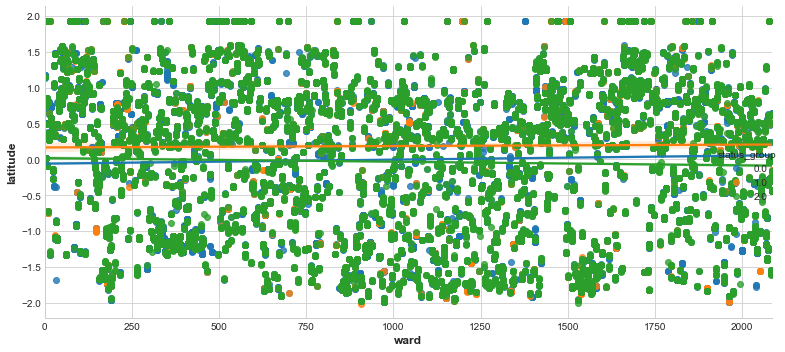

In [395]:
sns.lmplot(x="ward", y="latitude", hue="status_group", data=df, height=5, aspect=2)


Interpretation: this plot shows how the latitude varies across different administrative wards, with colors indicating different waterpoint status groups (functional, non functional, etc.).

There's no strong linear pattern by ward, likely due to its encoded numeric nature (categorical values treated as continuous).
However, we may observe geographical clustering: status groups tend to be concentrated around certain latitude values, suggesting location may influence functionality.

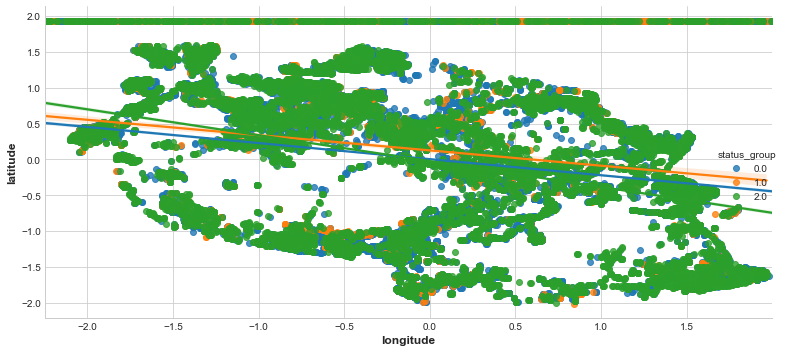

In [396]:
sns.lmplot(x="longitude", y="latitude", hue="status_group", data=df, height=5, aspect=2)


Interpretation: This scatterplot visualizes the geospatial distribution of waterpoints based on their longitude and latitude, with color indicating the status_group.

Clusters by Status Group: Distinct clusters of status groups suggest regional patterns in functionality. Some areas have higher concentrations of functional waterpoints, while others show more non-functional or needs repair.

Geographic Influence: The variation in status across locations implies geography (e.g., elevation, accessibility, or infrastructure) may influence waterpoint condition. This could be linked to environmental stress, infrastructure quality, or local governance.

Data Quality Insight: If any waterpoints appear around (0, 0) or with extreme long/lat values, those may be missing or erroneous coordinates.

# Creating Features

## Creating Pump_age

In [397]:
df["pump_age"] = df["year_recorded"] - df["construction_year"]


In [398]:
df["pump_age"]

0        12.0
1         3.0
2         4.0
3        27.0
4        15.0
         ... 
47515    16.0
47516    10.0
47517    19.0
47518    16.0
47519    15.0
Name: pump_age, Length: 47520, dtype: float64

## Create water_availability_index

In [399]:
df["water_availability_index"] = (
    df["amount_tsh"] + df["gps_height"]
) / 2
df["water_availability_index"]

0        1.416352
1        0.476646
2       -0.033752
3       -0.342837
4       -0.532558
           ...   
47515   -0.532558
47516    0.420379
47517    0.409558
47518   -0.534051
47519   -0.532558
Name: water_availability_index, Length: 47520, dtype: float64

In [400]:
# Use existing encoded columns directly
safety_features = ["water_quality", "source", "quality_group"]

# Calculate the safety score sum
df["water_safety_score_sum"] = df[safety_features].sum(axis=1)

# Calculate the safety score product
df["water_safety_score_product"] = df[safety_features].product(axis=1)


In [401]:
df["water_safety_score_product"]

0        96.0
1        60.0
2         0.0
3        36.0
4        60.0
         ... 
47515    16.0
47516    72.0
47517    72.0
47518    72.0
47519    84.0
Name: water_safety_score_product, Length: 47520, dtype: float64

# add lon_lat feature

In [402]:
df.head()

,public_meeting,permit,funder,installer,subvillage,wpt_name,scheme_name,payment_type,source,quality_group,...,longitude,month_recorded,population,region_code,year_recorded,construction_year,pump_age,water_availability_index,water_safety_score_sum,water_safety_score_product
0,1.0,0.0,217.0,72.0,217.0,2883.0,112.0,0.0,8.0,2.0,...,-0.075453,-0.453624,-0.148887,-0.244909,2011.0,1999.0,12.0,1.416352,16.0,96.0
1,0.0,1.0,39.0,29.0,39.0,671.0,23488.0,2.0,5.0,2.0,...,-0.166424,-0.453624,0.211544,0.264940,2013.0,2010.0,3.0,0.476646,13.0,60.0
2,1.0,1.0,7.0,573.0,7.0,2.0,8.0,5.0,0.0,2.0,...,0.883415,-0.784064,0.148311,0.321590,2013.0,2009.0,4.0,-0.033752,8.0,0.0
3,1.0,1.0,860.0,190.0,860.0,1.0,23488.0,2.0,3.0,2.0,...,1.273221,-1.114504,-0.256385,4.230433,2013.0,1986.0,27.0,-0.342837,11.0,36.0
4,1.0,1.0,1.0,113.0,1.0,1400.0,23488.0,2.0,5.0,2.0,...,-1.522644,0.868134,-0.378636,0.151640,2011.0,1996.0,15.0,-0.532558,13.0,60.0


In [403]:
df.to_csv("../data/processed/df_encoded_new_features.csv", index=False)

In [404]:
df_cluster = pd.read_csv("../data/processed/df_encoded_new_features.csv")

In [405]:
df_cluster.head()

,public_meeting,permit,funder,installer,subvillage,wpt_name,scheme_name,payment_type,source,quality_group,...,longitude,month_recorded,population,region_code,year_recorded,construction_year,pump_age,water_availability_index,water_safety_score_sum,water_safety_score_product
0,1.0,0.0,217.0,72.0,217.0,2883.0,112.0,0.0,8.0,2.0,...,-0.075453,-0.453624,-0.148887,-0.244909,2011.0,1999.0,12.0,1.416352,16.0,96.0
1,0.0,1.0,39.0,29.0,39.0,671.0,23488.0,2.0,5.0,2.0,...,-0.166424,-0.453624,0.211544,0.264940,2013.0,2010.0,3.0,0.476646,13.0,60.0
2,1.0,1.0,7.0,573.0,7.0,2.0,8.0,5.0,0.0,2.0,...,0.883415,-0.784064,0.148311,0.321590,2013.0,2009.0,4.0,-0.033752,8.0,0.0
3,1.0,1.0,860.0,190.0,860.0,1.0,23488.0,2.0,3.0,2.0,...,1.273221,-1.114504,-0.256385,4.230433,2013.0,1986.0,27.0,-0.342837,11.0,36.0
4,1.0,1.0,1.0,113.0,1.0,1400.0,23488.0,2.0,5.0,2.0,...,-1.522644,0.868134,-0.378636,0.151640,2011.0,1996.0,15.0,-0.532558,13.0,60.0


### Prepare dataset for calculating mutual information between features and the target variable status_group

In [ ]:
X = df_cluster.copy()
y = X.pop("status_group") # Removes the status_group column from X and stores it in y

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes.isin([int, float])

### a function to compute and rank mutual information scores

In [407]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their

ward                        0.185262
quantity                    0.103723
waterpoint_type             0.061184
funder                      0.056573
water_availability_index    0.052838
construction_year           0.038311
payment_type                0.034801
source                      0.022015
water_safety_score_sum      0.018301
basin                       0.015763
month_recorded              0.011032
year_recorded               0.009225
source_class                0.000600
Name: MI Scores, dtype: float64

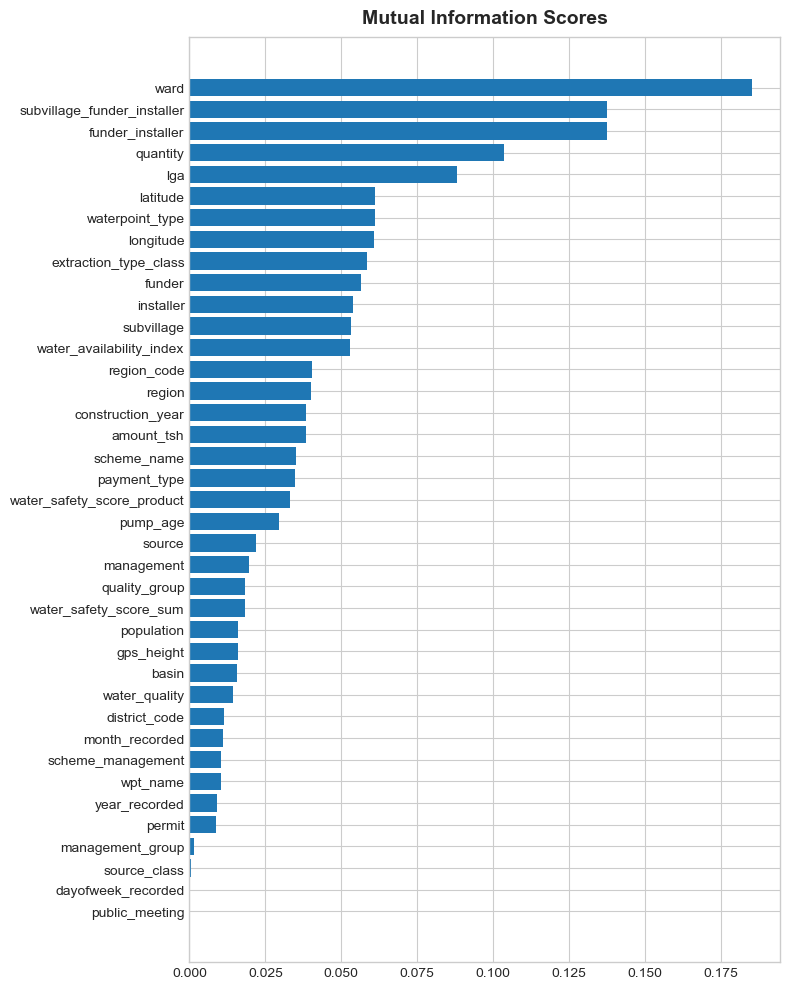

In [408]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores)

# Clustering With K-Means


### feature selection

In [409]:
# Select relevant numerical features for clustering
features_for_clustering = [
    'gps_height', 'latitude', 'longitude', 'population', 'amount_tsh',
    'pump_age', 'water_availability_index', 'water_safety_score_sum'
]

X = df_cluster[features_for_clustering]


### Scaling Features

In [410]:
# tip: K-Means is sensitive to magnitude — so we’ll scale features to mean 0 and variance 1.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Apply K-Means

In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)


Interpretation: Groups our waterpoints into 4 clusters based on patterns in features. The result helps us identify natural groupings, outliers, or patterns in the data.

 ### Visualize Clusters (2D with PCA)

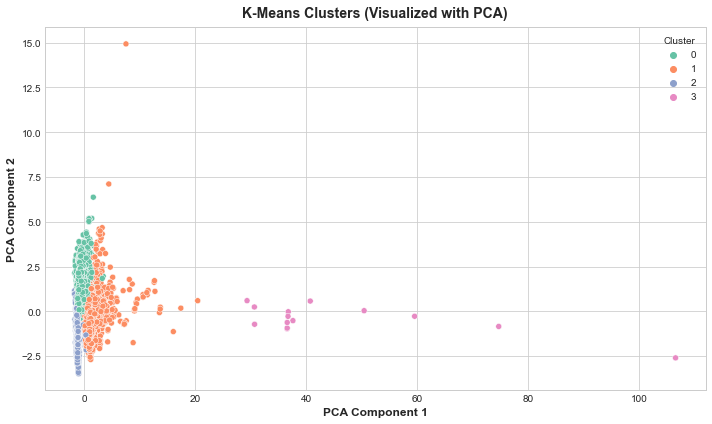

In [412]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot with seaborn
df_cluster['pca1'] = X_pca[:, 0]
df_cluster['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('K-Means Clusters (Visualized with PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


interpretation: 
this 2D PCA visualization of K-Means clustering results on selected waterpoint features. 

### Axes PCA1 and PCA2 
are principle components, compressed combinations of the original features that capture the most variance.They don’t have real-world units, but show directions of greatest spread in the data.

### Clusters hue = cluster
Each colored group (0, 1, 2, 3) represents a cluster formed by K-Means based on similarities in features like: gps_height, population, latitude, longitude, pump_age, etc.
Cluster 3 (purple) appears far to the right: These are likely outliers with extreme values (e.g., very high amount_tsh or unusual geography).

Clusters 0, 1, 2 are denser and more central: Likely represent typical groups of waterpoints (e.g., rural vs urban, or different functional types).

## How to use this: 
### underestand infrustructure types:
Groupings may reveal different waterpoint conditions, funding/installation practices, or regional characteristics.

### feature Engineering:
The cluster label can be added as a new feature in supervised models.

### Anomaly Detection
Isolated clusters (like #3) may signal maintenance or data quality issues.



### visualize the geographical clustring

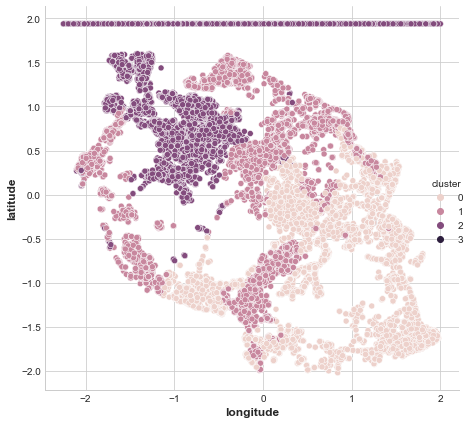

In [413]:
sns.relplot(
    x="longitude", y="latitude", hue="cluster", data=df_cluster, height=6
)

Interpretation: 
this shows how k-mean grouped waterpoints geographically.

each dot represent a waterpoint, and the color indicates which cluster it was assigned to based on its features.

Cluster 0 (orange): Concentrated more in southern and eastern regions.

Cluster 1 (blue): Appears across central regions.

Cluster 2 (green): Focused more in northern and slightly western areas.

Cluster 3 (red): Very sparse — likely outliers or unique points (e.g., remote or extreme feature values).

### This plot shows:

- Regional differences in waterpoint characteristics (e.g., age, altitude, availability).

- How location correlates with cluster assignment — suggesting geographic factors may influence waterpoint types or conditions.



In [414]:
kmeans.cluster_centers_


array([[-6.53810640e-01, -8.06139140e-01,  6.54958842e-01,
         2.85959288e-02, -5.92664707e-02, -6.27937337e-02,
        -4.87190330e-01, -1.65055601e-01],
       [ 1.09261758e+00,  1.69625907e-01, -1.01567607e-01,
         1.77099730e-01,  7.28961101e-02,  7.67957697e-03,
         7.96305187e-01,  1.47759405e-01],
       [-9.40447525e-01,  9.97556577e-01, -8.76785403e-01,
        -3.71020646e-01, -9.96513915e-02,  8.79981879e-02,
        -7.10618989e-01, -2.55402329e-03],
       [ 5.07696694e-01, -5.45015554e-01,  4.07924752e-01,
         3.46743559e-01,  4.75014666e+01, -1.68242400e-01,
         3.28009409e+01, -1.90225160e-01]])

In [415]:
# Compare cluster vs status_group
pd.crosstab(df_cluster['cluster'], df_cluster['status_group'])


status_group,0.0,1.0,2.0
cluster,,,
0,8582,1094,7628
1,11728,1438,6365
2,5465,944,4262
3,13,1,0


interpretation: 
### Clusters 0, 1, 2:
These are large, meaningful groupings.

Each contains a mix of status groups, but show some distinctions:

Cluster 1 has the highest number of functional waterpoints (0.0).

Cluster 0 has nearly equal numbers of functional and non-functional.

Cluster 2 is balanced, but smaller overall.

This indicates that K-Means found useful structure, even without knowing status_group.

### Cluster 3:
Very small (14 points): likely outliers or rare configurations.

These points might have extreme values in features like amount_tsh, population, or gps_height.


In [416]:

# Compute and display description for cluster 3
cluster_3_description = df_cluster[df_cluster['cluster'] == 3].describe()
cluster_3_description


,public_meeting,permit,funder,installer,subvillage,wpt_name,scheme_name,payment_type,source,quality_group,...,region_code,year_recorded,construction_year,pump_age,water_availability_index,water_safety_score_sum,water_safety_score_product,cluster,pca1,pca2
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.000000
mean,0.857143,0.928571,2367.500000,1710.000000,2367.500000,202.142857,3483.714286,1.214286,5.642857,2.0,...,-0.366302,2011.571429,1997.642857,13.928571,24.004582,13.642857,67.714286,3.0,45.939204,-0.449151
std,0.363137,0.267261,4193.957352,3877.347745,4193.957352,507.488516,8476.431673,1.050902,1.150728,0.0,...,0.204685,0.937614,12.851861,12.651934,11.244186,1.150728,13.808741,0.0,21.452967,0.807850
min,0.000000,0.000000,1.000000,8.000000,1.000000,1.000000,1.000000,0.000000,3.000000,2.0,...,-0.698109,2011.000000,1972.000000,1.000000,15.314597,11.000000,36.000000,3.0,29.308916,-2.594687
25%,1.000000,1.000000,8.000000,13.750000,8.000000,1.000000,65.000000,1.000000,6.000000,2.0,...,-0.528159,2011.000000,1993.000000,3.250000,19.094869,14.000000,72.000000,3.0,36.533686,-0.809786
50%,1.000000,1.000000,85.000000,211.500000,85.000000,1.500000,69.000000,1.000000,6.000000,2.0,...,-0.273234,2011.000000,1999.000000,12.500000,19.110739,14.000000,72.000000,3.0,36.719705,-0.395487
75%,1.000000,1.000000,1935.000000,685.500000,1935.000000,6.250000,327.000000,1.000000,6.000000,2.0,...,-0.244909,2012.500000,2007.750000,18.000000,25.082239,14.000000,72.000000,3.0,47.988250,0.024908
max,1.000000,1.000000,10013.000000,14371.000000,10013.000000,1400.000000,23488.000000,4.000000,7.000000,2.0,...,-0.018310,2013.000000,2011.000000,39.000000,55.786235,15.000000,84.000000,3.0,106.567563,0.600019


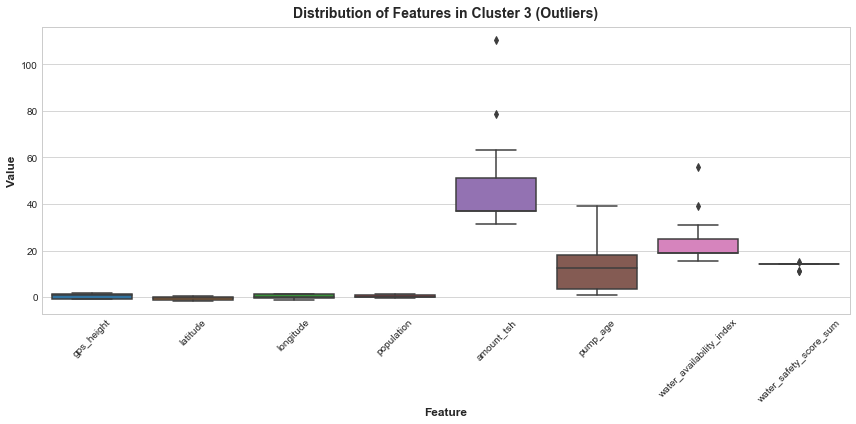

In [417]:
features = [
    'gps_height', 'latitude', 'longitude', 'population', 'amount_tsh',
    'pump_age', 'water_availability_index', 'water_safety_score_sum'
]
# Extract Cluster 3 data and melt for visualization
cluster_3_data = df_cluster[df_cluster['cluster'] == 3][features]
melted_data = cluster_3_data.melt(var_name='Feature', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', data=melted_data)
plt.xticks(rotation=45)
plt.title("Distribution of Features in Cluster 3 (Outliers)")
plt.tight_layout()
plt.show()


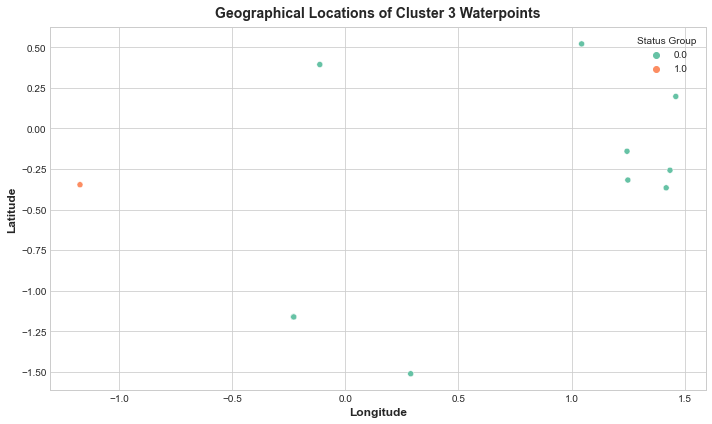

In [418]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only Cluster 3
cluster_3 = df_cluster[df_cluster['cluster'] == 3]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_3, x='longitude', y='latitude', hue='status_group', palette='Set2')
plt.title("Geographical Locations of Cluster 3 Waterpoints")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Status Group")
plt.grid(True)
plt.show()


In [419]:
df_cluster['is_outlier'] = df_cluster['cluster'] == 3


# Clustring

In [420]:
# Select features for clustering
cluster_features = [
    'gps_height', 'latitude', 'longitude', 'population', 'amount_tsh',
    'pump_age', 'water_availability_index', 'water_safety_score_sum'
]

# Standardize for clustering
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster[cluster_features])

# Apply K-Means to detect outlier cluster
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_cluster)

# Flag Cluster 3 as outliers
df_cluster['is_outlier'] = (df_cluster['cluster'] == 3).astype(int)

# Drop 'cluster' column if not needed
df_cluster.drop(columns=['cluster'], inplace=True)

# Your DataFrame now includes 'is_outlier' as a new feature
df_cluster.to_csv("../data/processed/df_outlier_flag.csv", index=False) 

In [421]:
df_cluster.head()

,public_meeting,permit,funder,installer,subvillage,wpt_name,scheme_name,payment_type,source,quality_group,...,region_code,year_recorded,construction_year,pump_age,water_availability_index,water_safety_score_sum,water_safety_score_product,pca1,pca2,is_outlier
0,1.0,0.0,217.0,72.0,217.0,2883.0,112.0,0.0,8.0,2.0,...,-0.244909,2011.0,1999.0,12.0,1.416352,16.0,96.0,2.918005,0.456584,0
1,0.0,1.0,39.0,29.0,39.0,671.0,23488.0,2.0,5.0,2.0,...,0.264940,2013.0,2010.0,3.0,0.476646,13.0,60.0,0.839102,-0.578021,0
2,1.0,1.0,7.0,573.0,7.0,2.0,8.0,5.0,0.0,2.0,...,0.321590,2013.0,2009.0,4.0,-0.033752,8.0,0.0,-0.312786,1.185545,0
3,1.0,1.0,860.0,190.0,860.0,1.0,23488.0,2.0,3.0,2.0,...,4.230433,2013.0,1986.0,27.0,-0.342837,11.0,36.0,-0.674557,2.190006,0
4,1.0,1.0,1.0,113.0,1.0,1400.0,23488.0,2.0,5.0,2.0,...,0.151640,2011.0,1996.0,15.0,-0.532558,13.0,60.0,-1.281675,-1.647462,0


In [422]:
df_outlier = pd.read_csv("../data/processed/df_outlier_flag.csv") 

# Principal Component Analysis


In [423]:
# Drop non-numeric and target-related features (like 'status_group', 'pca1', 'pca2', etc.)
exclude_cols = ['is_outlier', 'pca1', 'pca2']
pca_features = df_outlier.select_dtypes(include='number').drop(columns=exclude_cols, errors='ignore')


In [424]:
# Standardize the Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)


In [425]:
# Apply PCA
from sklearn.decomposition import PCA

# Keep enough components to explain ~95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])


In [426]:
# Combine PCA components with key metadata like 'is_outlier'
pca_df['is_outlier'] = df_outlier['is_outlier'].values


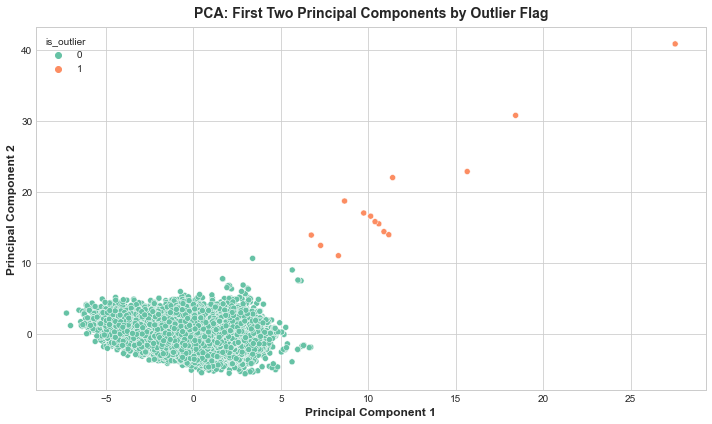

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='is_outlier', palette='Set2')
plt.title('PCA: First Two Principal Components by Outlier Flag')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# interpretation: 
X-axis = Principal Component 1 (PC1)
Y-axis = Principal Component 2 (PC2)

Each point = a waterpoint
Color (hue=is_outlier):
0 = normal (inlier)
1 = outlier (from K-Means Cluster 3)

## Clear Separation of Outliers
The orange points (outliers) are far to the right and upper part of the plot.
This tells us that PCA has captured the variance that separates outliers from the main group — meaning:
These points are truly distinct in the underlying feature space.
The separation is not random — outliers behave very differently across multiple features.

## Tightly Clustered Inliers
Most green points are compact and dense in the center and left.

This means that non-outlier waterpoints are similar to each other across the principal components.

summary: 
PCA confirms that outlier detection using K-Means was legitimate.

I can confidently use the is_outlier flag in my models.

I may want to analyze or handle outliers differently in downstream tasks (e.g., modeling, interventions, resource allocation).



## generate a PCA plot colored by status_group

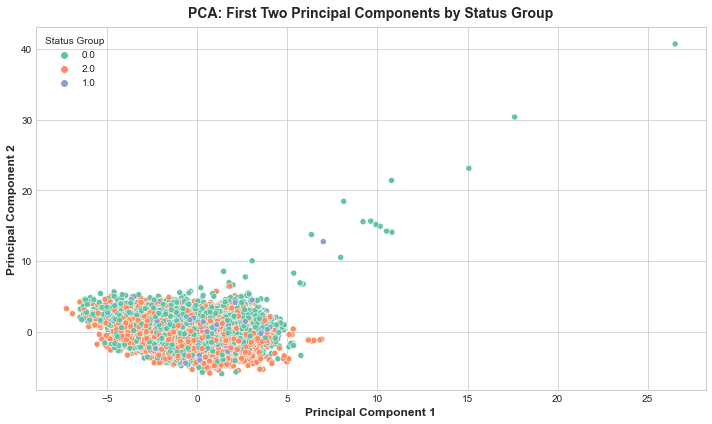

In [428]:
# Select numerical features for PCA (exclude metadata and PCA columns)
exclude_cols = ['is_outlier', 'status_group', 'pca1', 'pca2']
pca_features = df_outlier.select_dtypes(include='number').drop(columns=exclude_cols, errors='ignore')

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Combine PCA output with status_group
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['status_group'] = df_outlier['status_group'].astype(str)  # Ensure it's treated as categorical

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='status_group', palette='Set2')
plt.title('PCA: First Two Principal Components by Status Group')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Status Group')
plt.tight_layout()
plt.show()

### PCA Plot Interpretation (Colored by status_group):

The plot shows the first two principal components (PC1 and PC2), which capture the largest variance in the dataset.

Most points from different status groups (0.0, 1.0, 2.0) overlap in the central region of the PCA space.

This indicates that the selected features do not linearly separate the status groups well.

Some functional points (0.0) are spread further along PC1, suggesting the presence of functional outliers or unique feature combinations.

Points labeled as 1.0 (needs repair) are fewer and more scattered, indicating class imbalance and weaker separation.

Conclusion:

The data is not linearly separable in 2D, so non-linear models like Random Forest or XGBoost are more appropriate.

Use is_outlier as a feature to help the model recognize unusual patterns.

Consider addressing class imbalance for better handling of underrepresented classes.

# Target Encoding

In [429]:
target = 'status_group'
categorical_cols = ['funder', 'installer', 'subvillage']  


In [ ]:
for col in categorical_cols:
    # Create the mapping of category > target mean
    target_mean = df_outlier.groupby(col)[target].mean()

    # Apply the mapping to create a new encoded column
    df_outlier[f'{col}_target_enc'] = df_outlier[col].map(target_mean)


In [431]:
df_outlier[[*categorical_cols, *(f'{col}_target_enc' for col in categorical_cols)]].head()


,funder,installer,subvillage,funder_target_enc,installer_target_enc,subvillage_target_enc
0,217.0,72.0,217.0,0.331797,0.763889,0.331797
1,39.0,29.0,39.0,0.589744,0.241379,0.589744
2,7.0,573.0,7.0,0.660714,0.628272,0.660714
3,860.0,190.0,860.0,0.758140,1.073684,0.758140
4,1.0,113.0,1.0,0.721550,0.831858,0.721550


In [ ]:
df_outlier.drop(columns=categorical_cols, inplace=True)

In [433]:
df_outlier.head()

,public_meeting,permit,wpt_name,scheme_name,payment_type,source,quality_group,funder_installer,management_group,lga,...,pump_age,water_availability_index,water_safety_score_sum,water_safety_score_product,pca1,pca2,is_outlier,funder_target_enc,installer_target_enc,subvillage_target_enc
0,1.0,0.0,2883.0,112.0,0.0,8.0,2.0,2138.0,4.0,51.0,...,12.0,1.416352,16.0,96.0,2.918005,0.456584,0,0.331797,0.763889,0.331797
1,0.0,1.0,671.0,23488.0,2.0,5.0,2.0,843.0,4.0,103.0,...,3.0,0.476646,13.0,60.0,0.839102,-0.578021,0,0.589744,0.241379,0.589744
2,1.0,1.0,2.0,8.0,5.0,0.0,2.0,1328.0,4.0,108.0,...,4.0,-0.033752,8.0,0.0,-0.312786,1.185545,0,0.660714,0.628272,0.660714
3,1.0,1.0,1.0,23488.0,2.0,3.0,2.0,2694.0,4.0,87.0,...,27.0,-0.342837,11.0,36.0,-0.674557,2.190006,0,0.758140,1.073684,0.758140
4,1.0,1.0,1400.0,23488.0,2.0,5.0,2.0,28.0,1.0,26.0,...,15.0,-0.532558,13.0,60.0,-1.281675,-1.647462,0,0.721550,0.831858,0.721550
